# Demonstration of Structured State Space Models (S4)
This code adapts and simplifies the core functionality from [HiPPO demonstration](https://github.com/state-spaces/s4/blob/main/notebooks/hippo_function_approximation.ipynb) of the official S4 repository.

It shows in detail the following concepts
- Generation of the $A$ and $B$ matrices using the scaled legendre measure
- Projection of a function $f(t)$ into the coefficients $c$
- Construction of the approximation $g(t)$ from the coefficients $c$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_legendre
from utils.ssm import discretize
from utils.common import whitesignal

## 1) High Order Polynomial Projections (HiPPO)
The Idea behind HiPPO is to project a continuous signal $f(t)$ into a different basis $P_i$ using a fixed number of coefficients $c_i$.

We can then reconstruct an approximation $g(t)$ by evaluating the basis.

### 1.1) Generating the HiPPO LegS matrices $A$ and $B$
For the scaled Legendre Measure (HiPPO-LegS) the matrices are defined as follows.
$$
\begin{aligned}
A_{nk} &= -\begin{cases}\begin{aligned}&(2n+1)^\frac{1}{2}(2k+1)^\frac{1}{2} &if\ n>k\\&n+1 &if\ n=k\\&0 &if\ n<k\\\end{aligned}\end{cases}\\
B_n &= (2n+1)^\frac{1}{2}
\end{aligned}
$$

In [2]:
def hippo_legs(N: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Initializes HiPPO-LegS matrices A and B.

    Parameters:
        N (int): number of Legendre polynomials to use

    Returns:
        (A, B) (ndarray, ndarray): state transition matrix A and input matrix B
    """
    A = np.zeros((N, N))
    B = np.zeros((N,))
    for n in range(N):
        B[n] = np.sqrt(2*n + 1)
        for k in range(N):
            if n > k:
                A[n, k] = - (np.sqrt(2*n + 1) * np.sqrt(2*k + 1))
            elif n == k:
                A[n, k] = - (n + 1)
            else:
                A[n, k] = 0
    return A, B

In [3]:
# Show the matrices A and B for N=4
A, B = hippo_legs(4)
display(A)
display(B)

array([[-1.        ,  0.        ,  0.        ,  0.        ],
       [-1.73205081, -2.        ,  0.        ,  0.        ],
       [-2.23606798, -3.87298335, -3.        ,  0.        ],
       [-2.64575131, -4.58257569, -5.91607978, -4.        ]])

array([1.        , 1.73205081, 2.23606798, 2.64575131])

### 1.2) Projection of a function $f(t)$ into coefficients $c$
We can project the function $f(t)$ into a basis of legendre polynomials. This yields the coefficients $c$.

We do this by iteratively applying the State equation.

$$
c_k = \bar{A}c_{k-1} + \bar{B}f_{k}
$$

We take the final coefficients as a result.

**TODO: is this correct?**

In [4]:
def project(f: np.ndarray, A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Projects a time-series f(t) into a coefficient vector c representing the Legendre polynomial expansion.\\
    Each time step updates the coefficients using the discretized HiPPO system.

    Parameters:
        f (ndarray): time-series data to project
        A (ndarray): state transition matrix
        B (ndarray): input matrix

    Returns:
        c (ndarray): coefficients of the Legendre polynomial expansion
    """
    c = np.zeros_like(B)
    for i, f_t in enumerate(f):
        A_t = A / (i + 1)   # TODO: why???
        B_t = B / (i + 1)
        A_d, B_d = discretize(A_t, B_t, 1.0)  # dt=1 since scale handles time
        c = A_d @ c + B_d * f_t     # iteratively apply state equation to update coefficients
    return c

### 1.3) Reconstruction of the approximation $g(t)$
We can construct the approximation $g(t) \approx f(t)$ by evaluating the legendre polynomials $P_i$, weighting them with the corresponding coefficients $c_i$ and summing the results.

$$
g(t) = \sum_{i=0}^N c_i P_i(t)
$$

In [5]:
def reconstruct(c: np.ndarray, n_samples: int) -> np.ndarray:
    """
    Given Legendre coefficients c, reconstruct the function approximation.

    Parameters:
        c (ndarray): coefficients of the Legendre polynomial expansion
        n_samples (int): number of samples to generate for the approximation

    Returns:
        approx (ndarray): reconstructed function values
    """
    t = np.linspace(-1, 1, n_samples)   # Legendre polynomials are defined on [-1, 1]
    approx = np.zeros_like(t)
    for i, c_i in enumerate(c):
        P_i = eval_legendre(i, t)
        approx += c_i * P_i
    return approx

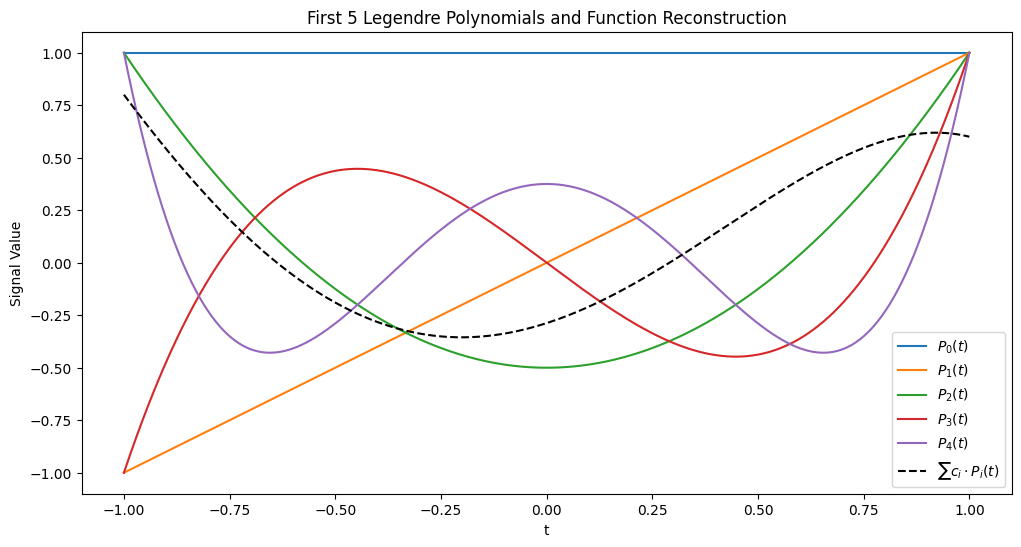

In [6]:
# Plot the first 5 legendre polynomials and a reconstructed function using random coefficients
c = [0.1, 0.2, 0.7, -0.3, -0.1]
n_samples = 1000
t = np.linspace(-1, 1, n_samples)

# Plot legendre polynomials
plt.figure(figsize=(12, 6))
for i, c_i in enumerate(c):
    P_i = eval_legendre(i, t)
    plt.plot(t, P_i, label=f'$P_{i}(t)$')

# Plot the reconstruction
approx = reconstruct(c, n_samples)
plt.plot(t, approx, label=r'$\sum c_i \cdot P_i(t)$', linestyle='--', color='black')

plt.title(f'First {len(c)} Legendre Polynomials and Function Reconstruction')
plt.xlabel('t')
plt.ylabel('Signal Value')
plt.legend(loc='lower right')

### 1.4) Approximating a signal using HiPPO
The code below approximates a signal $f(t) \approx g(t)$ by projecting it into a basis of legendre polynomials and then reconstring it using the coefficients $c$.

Note that we use a very small number of legendre polynomials to make the difference between $f(t)$ and $g(t)$ in the plot more visible. Using more polynomials leads to much results.

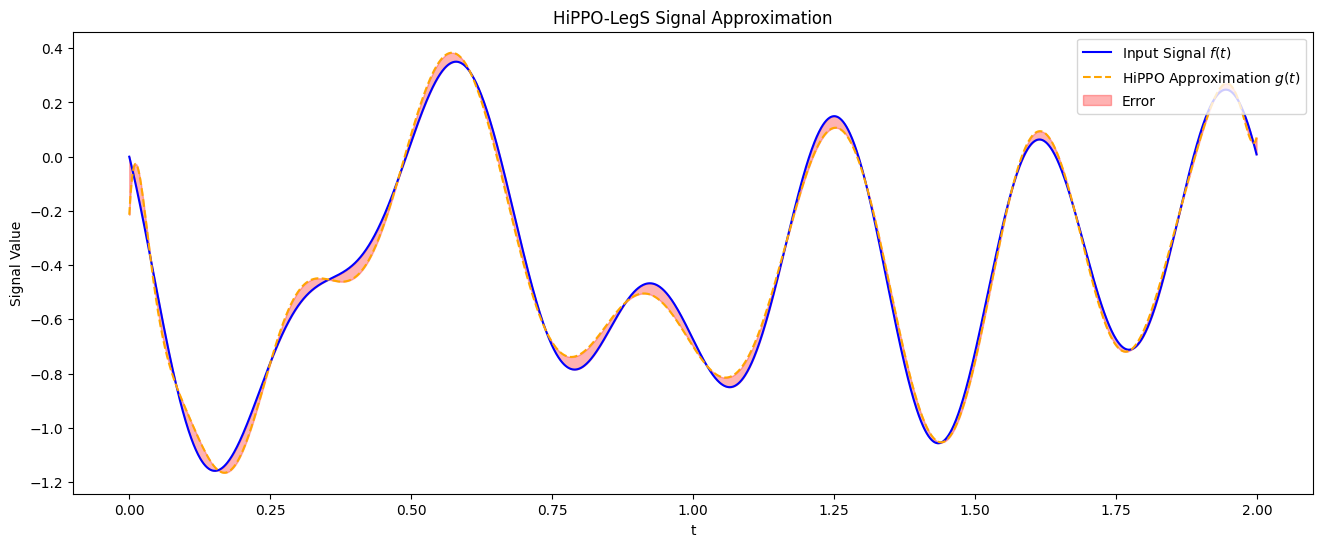

In [7]:
# Plotting the original and approximated signal

# Parameters
T=2         # Time period
dt=1e-3     # Time step
N=20        # Number of Legendre polynomials (Choose N=32 for near perfect approximation!)
freq=3.0    # Frequency of the signal
np.random.seed(42)  # For reproducibility

# Original signal
t = np.arange(0.0, T, dt)
f_t = whitesignal(T, dt, freq=freq) # Reference: https://github.com/state-spaces/s4/blob/main/notebooks/hippo_function_approximation.ipynb

# Approximated signal
A, B = hippo_legs(N)
c = project(f_t, A, B)
c_scaled = B * c    # Scale the coefficients with B because legendre polynomials aren't orthonormal
g_t = reconstruct(c_scaled, len(t))

# Plotting the results
plt.figure(figsize=(16, 6))
plt.plot(t, f_t, color='blue', label='Input Signal $f(t)$')
plt.plot(t, g_t, color='orange', linestyle='dashed', label='HiPPO Approximation $g(t)$')
plt.fill_between(t, f_t, g_t, color='red', alpha=0.3, label='Error')

plt.title('HiPPO-LegS Signal Approximation')
plt.xlabel('t')
plt.ylabel('Signal Value')
plt.legend(loc='upper right')
plt.show()
plt.close()

## 2) Diagonalization
Calculating the convolution kernel $\bar{K}$ is computationally expensive because it requires raising $\bar{A}$ to the power of $k$.
By using a diagonal matrix $\bar{A}$ this is replaced with powering each element individually, as can be seen in this example.

$$
\bar{A}^2 = \bar{A} \cdot \bar{A} = \begin{bmatrix}
a_1 & 0 & \cdots & 0\\
0 & a_2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & a_N
\end{bmatrix}
\cdot
\begin{bmatrix}
a_1 & 0 & \cdots & 0\\
0 & a_2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & a_N
\end{bmatrix}=
\begin{bmatrix}
a_1^2 & 0 & \cdots & 0\\
0 & a_2^2 & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & a_N^2
\end{bmatrix}
$$

We can diagonalize the $A$ matrix as follows.

$$
\Lambda = P^{-1} A P
$$

Where $P$ and $\Lambda$ are the eigenvectors and diagonalized eigenvalues of $A$.
We can use the `diagonalize()` function from sympy to calculate $P$ and $\Lambda$.

We can then reconstruct $A$:
$$
A = P \Lambda P^{-1}
$$

In [8]:
# Code adapted from: https://tinkerd.net/blog/machine-learning/state-space-models/
from sympy import Matrix

# Get HiPPO A Matrix using the helper function defined before
A, B = hippo_legs(16)

# Convert A to a sympy matrix
A = Matrix(A)

# Diagonalize A to obtain P and the diagonal matrix Lambda
P, Lambda = A.diagonalize()

# Compute the inverse of P
Pinv = P.inv()

# Get the maximum value in P and Pinv
P_np = np.array(P).astype(np.complex128)
P_inv_np = np.array(Pinv).astype(np.complex128)

max_value = max(
    P_np.real.max(),
    P_np.imag.max(),
    P_inv_np.real.max(),
    P_inv_np.imag.max()
)
print(f"Max Value: {max_value:.3f}")

# Reconstruct A from Lambda
A_r = P * Lambda * Pinv

# Check if the reconstructed matrix is close to the original
assert np.allclose(
    np.array(A).astype(np.complex128),
    np.array(A_r).astype(np.complex128),
    atol=1e-2
)

Max Value: 4241000415.639


We can see that even for a small HiPPO Matrix of size $16 \times 16$, we have very large values in $P$, making it numerically unstable.

This can also be seen by the reconstruction $P \Lambda P^{-1}$ being not very close to the original matrix $A$. If you replace the absolute tolerance parameter `atol=1e-2` above with 1e-3 or lower, the assertion will fail.